In [1]:

import vectorbt as vbt
import numpy as np
import pandas as pd
import warnings
from numba import jit

warnings.filterwarnings('ignore')

In [18]:
df1 = pd.read_csv("D:/quant_datas/etf/510050.csv")
df1=df1[['datetime', 'high', "low", "open"]]
df1.index = pd.to_datetime(df1["datetime"])
df1 = df1[df1.index>=pd.to_datetime("2011-09-20")]
df1.drop('datetime', axis=1, inplace=True)

print(df1)

             high    low   open
datetime                       
2011-09-20  1.928  1.905  1.913
2011-09-21  1.976  1.909  1.917
2011-09-22  1.958  1.912  1.953
2011-09-23  1.909  1.876  1.889
2011-09-26  1.905  1.849  1.886
...           ...    ...    ...
2023-12-25  2.976  2.962  2.968
2023-12-26  2.971  2.953  2.970
2023-12-27  2.970  2.947  2.961
2023-12-28  3.022  2.960  2.962
2023-12-29  3.027  3.007  3.012

[2984 rows x 3 columns]


In [20]:
@jit(nopython=True)
def f(x):
    x1 = x[:, 1]
    y = x[:, 0] 
    beta = 1 / np.sum(x1*x1) * np.sum(x1*y) 
    return beta

t = df1.rolling(18, method='table').apply(f, raw=True, engine='numba')
df1['beta'] = t.iloc[:, 0]
df1.dropna(inplace=True)
df1


,high,low,open,beta
datetime,,,,
2011-11-14,1.982,1.952,1.956,1.016677
2011-11-15,1.978,1.962,1.972,1.015902
2011-11-16,1.968,1.909,1.967,1.016904
2011-11-17,1.925,1.907,1.918,1.015774
2011-11-18,1.905,1.878,1.900,1.015275
...,...,...,...,...
2023-12-25,2.976,2.962,2.968,1.010536
2023-12-26,2.971,2.953,2.970,1.010603
2023-12-27,2.970,2.947,2.961,1.010412


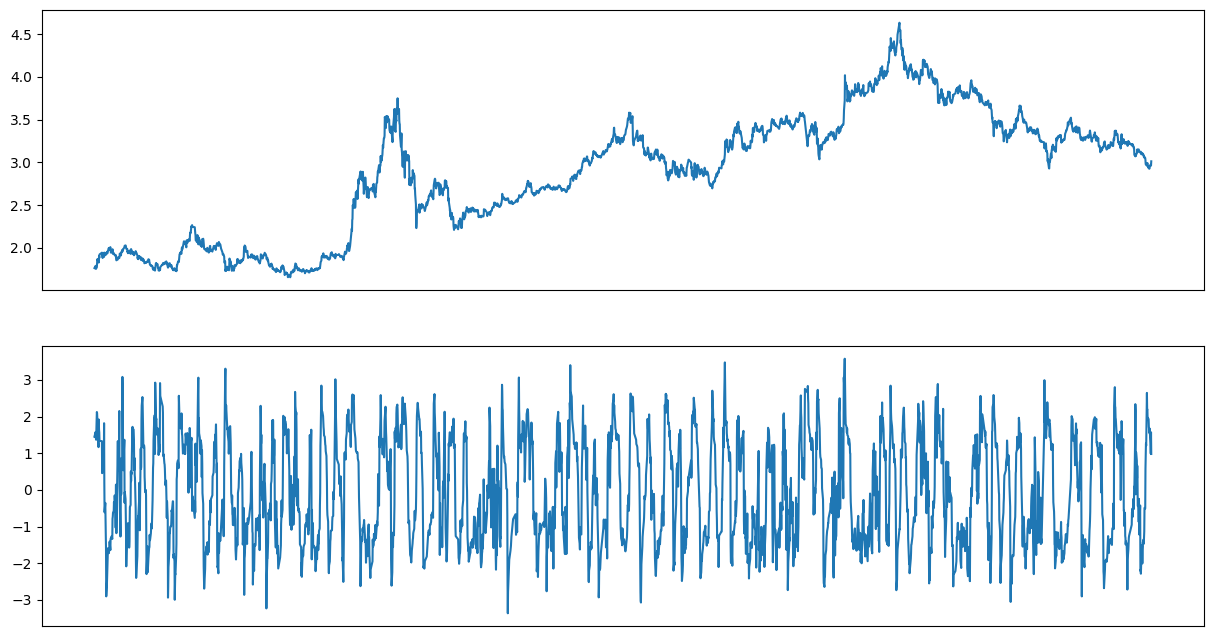

In [22]:

# 滚动标准化
df1['RSRS_mean'] = df1['beta'].rolling(18).mean()
df1['RSRS_std'] = df1['beta'].rolling(18).std()
df1['RSRS'] = (df1['beta'] - df1['RSRS_mean']) / df1['RSRS_std']
df1.dropna(inplace=True)

import matplotlib.pyplot as plt
# 画个图, 看看价格和斜率时什么关系
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
ax[0].plot(df1['open'])
ax[1].plot(df1['RSRS'])
ax[0].set_xticks([])
ax[1].set_xticks([])
plt.show()

In [24]:
df1['entries'] = np.where(df1['RSRS']>0.7, True, False)
df1['exit'] = np.where(df1['RSRS']<-0.7, True, False)
df1

,high,low,open,beta,RSRS_mean,RSRS_std,RSRS,entries,exit
datetime,,,,,,,,,
2011-12-30,1.781,1.761,1.762,1.016694,1.014807,0.001300,1.451372,True,False
2012-01-04,1.790,1.756,1.788,1.017195,1.014986,0.001397,1.581123,True,False
2012-01-05,1.782,1.750,1.752,1.017247,1.015163,0.001473,1.414986,True,False
2012-01-06,1.769,1.751,1.756,1.017458,1.015350,0.001540,1.368322,True,False
2012-01-09,1.825,1.758,1.772,1.019207,1.015710,0.001646,2.125009,True,False
...,...,...,...,...,...,...,...,...,...
2023-12-25,2.976,2.962,2.968,1.010536,1.009027,0.001133,1.331470,True,False
2023-12-26,2.971,2.953,2.970,1.010603,1.009215,0.001096,1.266736,True,False
2023-12-27,2.970,2.947,2.961,1.010412,1.009372,0.001049,0.990572,True,False


In [25]:
# 开始回测
pf = vbt.Portfolio.from_signals(df1['open'], df1['entries'], df1['exit'])
pf.trades.plot() # 红色时你亏的地方, 绿色是你赚的地方

FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'd2f3f4e3-085a-4f0a-a97f-034daf4a16ed',
              'x': array([datetime.datetime(2011, 12, 30, 0, 0),
                          datetime.datetime(2012, 1, 4, 0, 0),
                          datetime.datetime(2012, 1, 5, 0, 0), ...,
                          datetime.datetime(2023, 12, 27, 0, 0),
                          datetime.datetime(2023, 12, 28, 0, 0),
                          datetime.datetime(2023, 12, 29, 0, 0)], dtype=object),
              'y': array([1.762, 1.788, 1.752, ..., 2.961, 2.962, 3.012])},
             {'customdata': array([[0, 0, 56.75368898978434, 0.0, 'Long'],
                                   [1, 1, 58.76428666736124, 0.0, 'Long'],
                                   [2, 2, 59.28731958534299, 0.0, 'Long'],
                                   ...,
                                  